# 0. Import neccesary libraries

In [1]:
import os
import math
import torch
from torchvision.transforms import Compose
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

# 1. Visualize the dataset

In [2]:
class MUSDB18Spectrogram:
    """
    Class to compute and visualize spectrograms of audio files.
    
    Args:
        wav_file_path (str): Path to the WAV file.
        
    Attributes:
        wav_file_path (str): Path to the WAV file.
        audio_name (str): Name of the audio file extracted from the path.
        signal (np.ndarray): Audio signal loaded from the WAV file.
        sample_rate (int): Sample rate of the audio signal.
        f (np.ndarray): Frequency bins of the spectrogram.
        t (np.ndarray): Time bins of the spectrogram.
        spectrogram (np.ndarray): Computed spectrogram of the audio signal.
    """
    def __init__(self, spectrogram_tensor: torch.tensor, name: str='NONAME'):
        """
        Initializes the MUSDB18Spectrogram object.
        """
        self.spectrogram_mix = spectrogram_tensor[0,:,:][None, :]
        self.spectrogram_voc = spectrogram_tensor[1,:,:][None, :]
        self.t = torch.arange(self.spectrogram_mix.shape[2])  # Time bins
        self.f = torch.arange(self.spectrogram_mix.shape[1])  # Frequency bins
        self.name = name

    def visualize(self):
        """
        Visualize the spectrograms.
        """
        # Plot the spectrograms
        fig, axes = plt.subplots(2, 1, figsize=(20, 10))

        # Plot the mixture spectrogram
        im1 = axes[0].pcolormesh(self.t, self.f, 10 * torch.log10(self.spectrogram_mix[0] + 1e-8), cmap='inferno')  # Applying log scale for better visualization
        axes[0].set_ylabel('Frequency bin F (Hz)')
        axes[0].set_xlabel('Samples T (s)')
        axes[0].set_title(f'Mixture Spectrogram of {self.name}')
        plt.colorbar(im1, ax=axes[0], label='Intensity (dB)')  # Add colorbar to the subplot

        # Plot the vocals spectrogram
        im2 = axes[1].pcolormesh(self.t, self.f, 10 * torch.log10(self.spectrogram_voc[0] + 1e-8), cmap='inferno')  # Applying log scale for better visualization
        axes[1].set_ylabel('Frequency bin F (Hz)')
        axes[1].set_xlabel('Samples T (s)')
        axes[1].set_title(f'Vocals Spectrogram of {self.name}')
        plt.colorbar(im2, ax=axes[1], label='Intensity (dB)')  # Add colorbar to the subplot

        plt.show()  # Display the plot



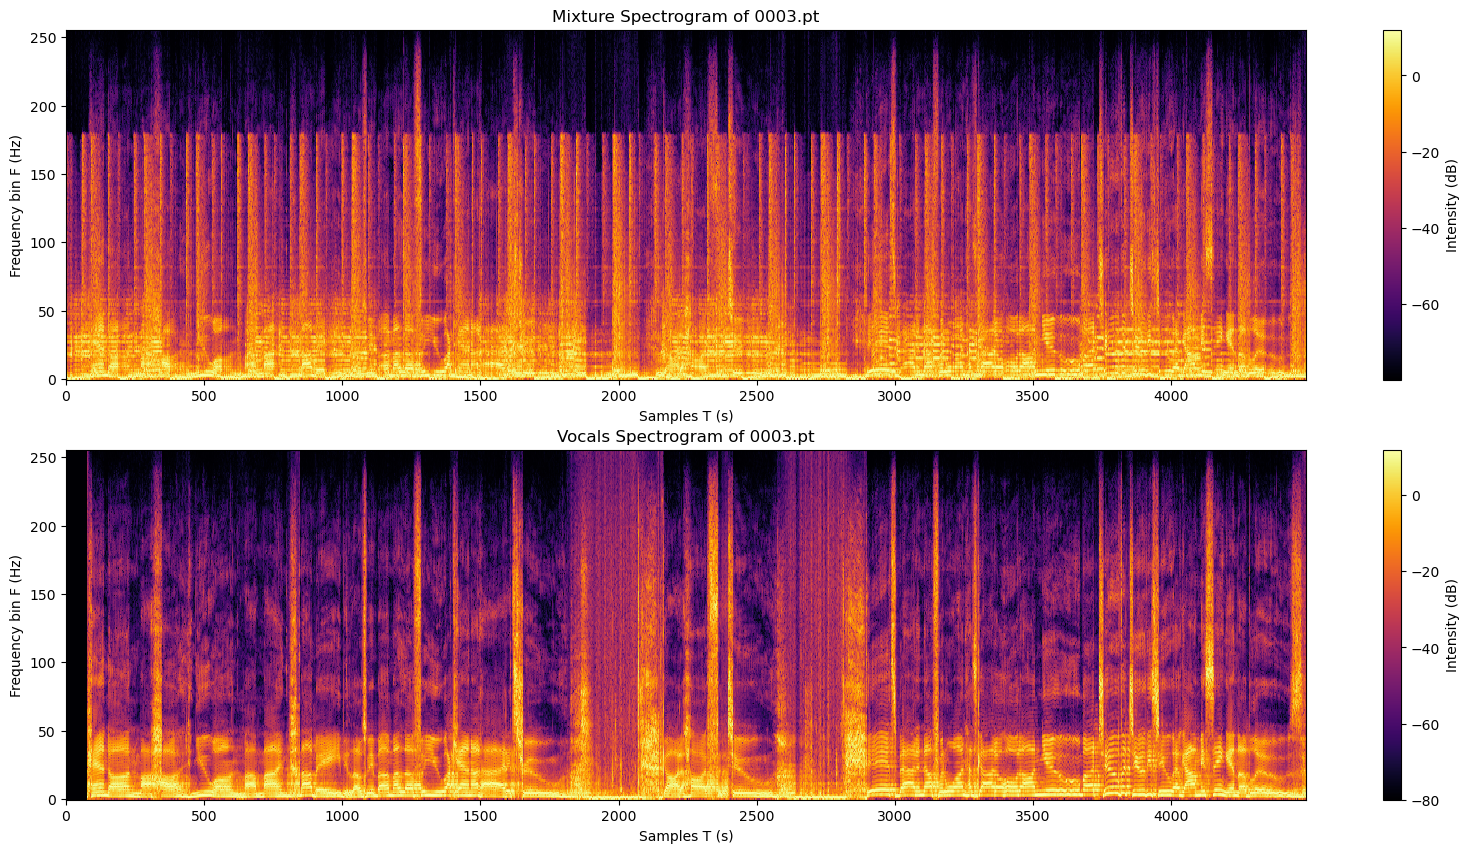

torch.Size([1, 256, 4488])

In [3]:
filename = './music_data/musdb18hq_processed/train_spectrograms/0003.pt'
spectrogram_tensor = torch.load(filename)
my_spectrogram = MUSDB18Spectrogram(spectrogram_tensor, filename[-7:])
my_spectrogram.visualize()

my_spectrogram.spectrogram_voc.shape

# 2. Create Dataset

In [5]:
class MUSDB18Dataset(Dataset):
    """
    Dataset class for MUSDB18 spectrograms.

    Args:
        root (str): Root directory containing the spectrogram files.
        transform (callable, optional): Optional transform to be applied to the spectrogram samples.
                                        Defaults to None.
    """

    def __init__(self, root: str, transform=None):
        """
        Initializes the MUSDB18Dataset object.

        Loads and processes the MUSDB18 dataset stored as spectrograms in the specified `root` directory.
        Each file in the directory is expected to contain precomputed spectrogram data for audio tracks.

        Args:
            root (str): Root directory containing the spectrogram files.
            transform (callable, optional): Optional transform to be applied to the spectrogram samples.
                                            It can be used for data augmentation or preprocessing.
                                            Defaults to None.

        Raises:
            FileNotFoundError: If the specified `root` directory does not exist.
        """
        if not os.path.exists(root):
            raise FileNotFoundError(f"Directory '{root}' not found.")

        self.root = root
        self.transform = transform
        self.data = []  # List to store processed spectrogram samples
        self.samples_per_data = 256  # Number of samples per spectrogram file

        # Iterate through files in the root directory
        for filename in os.listdir(self.root):
            # Load and process the spectrogram data from each file
            spectrogram_tensor = torch.load(os.path.join(self.root, filename))
            
            # Divide the spectrogram into segments of size `samples_per_data`
            for i in range(math.floor(spectrogram_tensor.shape[2] / self.samples_per_data)):
                # Extract a segment of the spectrogram
                segment_tensor = spectrogram_tensor[:, :, i * self.samples_per_data:(i + 1) * self.samples_per_data]
                
                # Create a new MUSDB18Spectrogram object with the segment and filename information
                new_tens = MUSDB18Spectrogram(segment_tensor, f'{filename}, part {i}')
                
                # Add the processed spectrogram segment to the dataset
                self.data.append(new_tens)

    def __getitem__(self, index: int):
        """
        Get sample by index.

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the mixture and vocals spectrogram samples.
        """
        # Access the stored path and label for the correct index
        spectrogram = self.data[index]

        if self.transform is not None:
            return self.transform(spectrogram.spectrogram_mix), self.transform(spectrogram.spectrogram_voc)
        else:
            return spectrogram.spectrogram_mix, spectrogram.spectrogram_voc
    
    def __len__(self):
        """
        Total number of samples in the dataset.

        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.data)
    
    def show_spectrogram(self, index: int):
        """
        Visualize the mixture and vocals spectrograms for the given index.

        Args:
            index (int): Index of the sample to visualize.
        """
        mix, voc = self.__getitem__(index)
        MUSDB18Spectrogram(torch.cat((mix, voc), 0), self.data[index].name).visualize()
        
        

In [5]:
from torchvision.transforms import Normalize, GaussianBlur, ToTensor

train_spectrogram_library = './music_data/musdb18hq_processed/train_spectrograms/'
val_spectrogram_library = './music_data/musdb18hq_processed/val_spectrograms/'
test_spectrogram_library = './music_data/musdb18hq_processed/test_spectrograms/'

mean = [0.485]
std = [0.229] 

transform_composition = Compose([Normalize(mean=mean,std=std), GaussianBlur(5)])
music_dataset_train = MUSDB18Dataset(train_spectrogram_library, transform_composition)
music_dataset_val = MUSDB18Dataset(val_spectrogram_library, transform_composition)
music_dataset_test = MUSDB18Dataset(test_spectrogram_library, transform_composition)


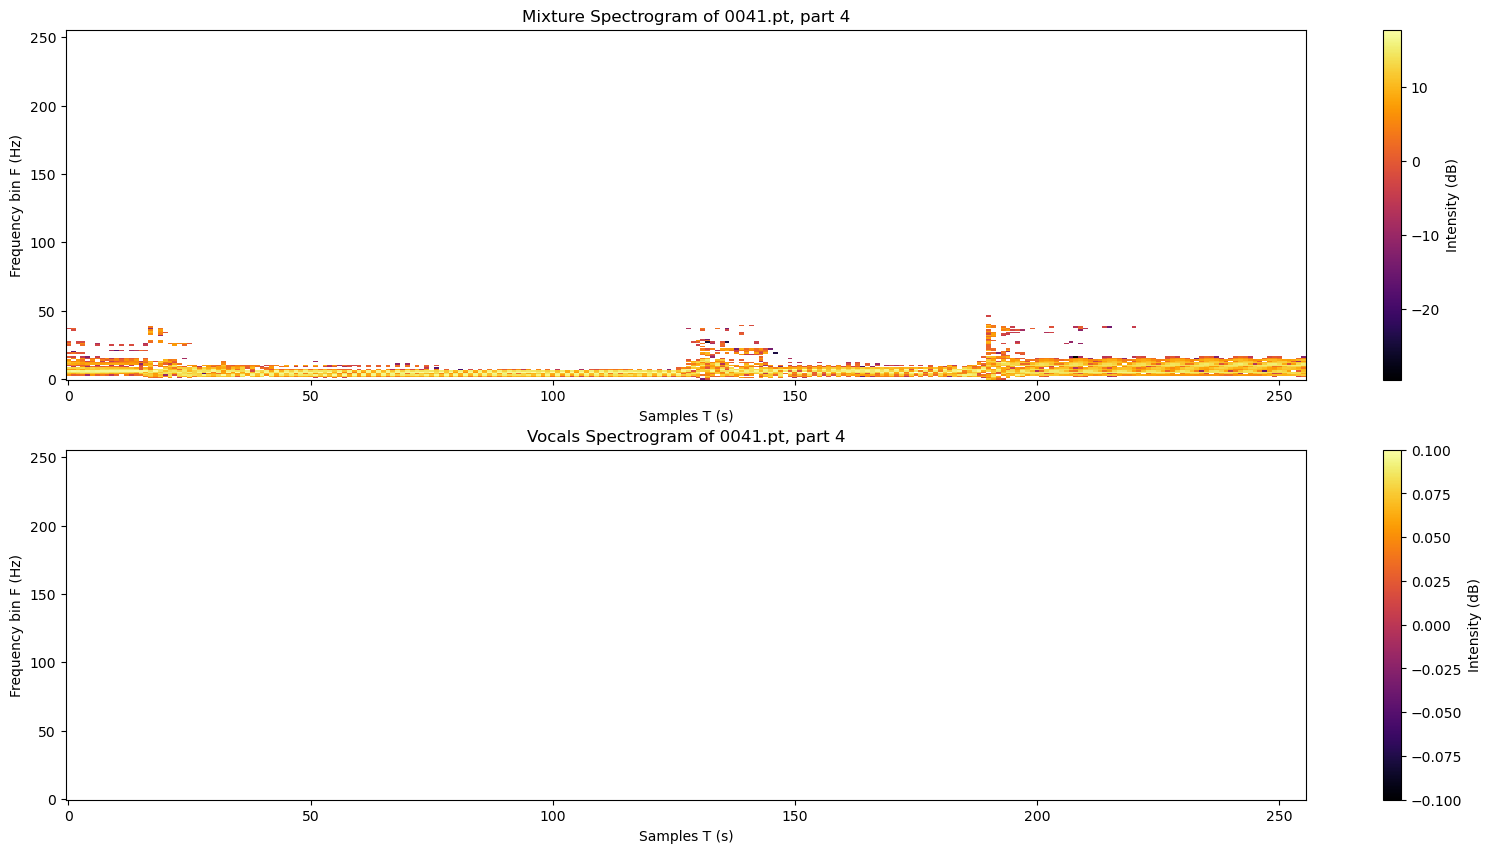

In [20]:
# Show how the transform has impacted the image / spectrogram
music_dataset_test.show_spectrogram(index=4)

# 3. Create DataLoader

In [21]:
train_dataloader = torch.utils.data.DataLoader(music_dataset_train, batch_size=1, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(music_dataset_val, batch_size=1, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(music_dataset_test, batch_size=1, shuffle=True)

# 4. Load UNET Model + Weights + Freeze encoder

In [25]:
from model import UnetModel

# Set the device which shoult host the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create instance of model
model = UnetModel()
model.transfer_weights(weight_path='./music_data/unet_latest.pth',device=device)
model.freeze_encoder_weights()

Loading weights for UNet


# 5. Train model

In [23]:
from trainer import UNETTrainer

# Create an Unet trainer with the dataloaders.
trainer = UNETTrainer(model=model, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

# Start training
trainer.train_model(num_epochs=1)

Starting training
Training on device: cpu


RuntimeError: all elements of target should be between 0 and 1